In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import nibabel as nb
import scipy.ndimage as ndimage

import CMR_HFpEF_Analysis.functions_collection as ff
import CMR_HFpEF_Analysis.Image_utils as util
import CMR_HFpEF_Analysis.LAX_validation.functions as LAX_func
main_path = '/mnt/mount_zc_NAS/HFpEF/data/Sunny_Brooks'

In [2]:
# define patient id:
patient_id = 'SC-HF-I-10'

# Code to register LAX on SAX:

In [3]:
# load data
lax = nb.load(os.path.join(main_path, 'sunnybrooks_nii', patient_id, 'LAX_4CH_ED_endo.nii.gz'))
lax_img = lax.get_fdata()
# if lax has four dimensions
if len(lax_img.shape) == 4:
    lax_img = lax_img[:,:,0,:]

sax = nb.load(os.path.join(main_path, 'sunnybrooks_nii', patient_id, 'SAX_ED.nii.gz'))
sax_img = sax.get_fdata()

lax_affine = lax.affine
sax_affine = sax.affine

In [4]:
lax_img[lax_img > 0] = 1
lax_pts = np.where(lax_img == 1)
grid_points = np.column_stack((lax_pts[0].flatten(), lax_pts[1].flatten(), lax_pts[2].flatten()))
converted_LAX_pts = ff.coordinate_convert(grid_points, sax_affine, lax_affine)
min_z = np.min(converted_LAX_pts[:,2])
print(min_z)

0.572870236491152


(58, 3)
[[130 129   0]
 [129 129   0]
 [128 129   0]
 [127 129   0]
 [126 129   0]
 [125 130   0]
 [124 130   0]
 [123 130   0]
 [122 130   0]
 [121 130   0]
 [120 130   0]
 [119 130   0]
 [118 130   0]
 [117 130   0]
 [116 131   0]
 [115 131   0]
 [114 131   0]
 [113 131   0]
 [112 131   0]
 [111 131   0]
 [110 131   0]
 [109 131   0]
 [108 132   0]
 [107 132   0]
 [129 129   0]
 [128 129   0]
 [127 129   0]
 [126 129   0]
 [125 130   0]
 [124 130   0]
 [123 130   0]
 [122 130   0]
 [121 130   0]
 [120 130   0]
 [119 130   0]
 [118 130   0]
 [117 130   0]
 [116 131   0]
 [115 131   0]
 [114 131   0]
 [113 131   0]
 [112 131   0]
 [111 131   0]
 [110 131   0]
 [109 131   0]
 [127 129   0]
 [126 129   0]
 [125 130   0]
 [124 130   0]
 [123 130   0]
 [122 130   0]
 [121 130   0]
 [120 130   0]
 [119 130   0]
 [118 130   0]
 [117 130   0]
 [116 131   0]
 [115 131   0]]


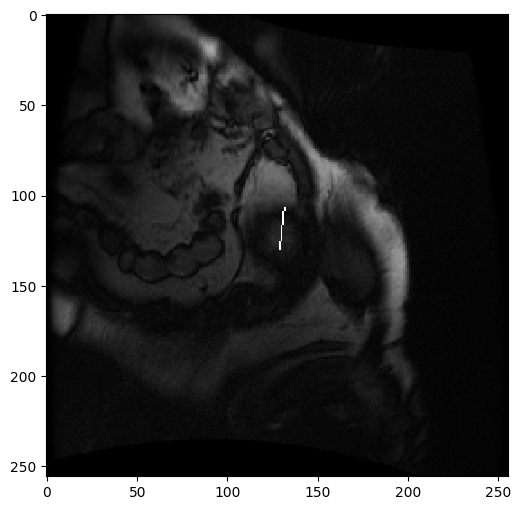

In [5]:
# convert LAX points to SAX coordinate
# lax_slice_num = 1

# X, Y, Z = np.meshgrid(np.arange(lax_img.shape[0]), np.arange(lax_img.shape[1]), np.arange(lax_slice_num, lax_slice_num + 1))
# grid_points = np.column_stack((X.flatten(), Y.flatten(), Z.flatten()))

# converted_LAX_pts = ff.coordinate_convert(grid_points, sax_affine, lax_affine)

sax_slice_num = 0
lax_on_sax, _, _, sax_img_new = LAX_func.find_LAX_on_SAX(converted_LAX_pts, sax_slice_num, sax_img)
plt.figure(figsize = (6,6))
plt.imshow(ff.set_window(sax_img_new[:,:,sax_slice_num],250,500), 'gray')  # compare it with the Horos results

# correct the motion misalignment using LAX-SAX intersection points

In [6]:
# find which LAXs we have (2CH, 3CH or 4CH)
names = ['LAX_2CH', 'LAX_3CH', 'LAX_4CH']
have = [0,0,0]
for i in range(0,3):
    lax_files = ff.find_all_target_files([names[i] + '*'], os.path.join(main_path, 'sunnybrooks_nii', patient_id))
    have[i] = [1 if len(lax_files) > 0 else 0][0]
folder = os.path.join(main_path, 'sunnybrooks_nii', patient_id, 'corrected')
ff.make_folder([folder])
    

In [7]:
# load sax images and segmentation
sax_img = nb.load(os.path.join(main_path, 'sunnybrooks_nii', patient_id, 'SAX_ED.nii.gz')).get_fdata()

sax_epi_img = nb.load(os.path.join(main_path, 'sunnybrooks_nii', patient_id, 'SAX_ED_epi.nii.gz')).get_fdata()
sax_epi_seg = np.copy(sax_epi_img); sax_epi_seg[sax_epi_seg > 0] = 1

sax_endo_img = nb.load(os.path.join(main_path, 'sunnybrooks_nii', patient_id, 'SAX_ED_endo.nii.gz')).get_fdata()
sax_endo_seg = np.copy(sax_endo_img); sax_endo_seg[sax_endo_seg > 0] = 1

sax_affine = nb.load(os.path.join(main_path, 'sunnybrooks_nii', patient_id, 'SAX_ED_endo.nii.gz')).affine

In [8]:
# collect LAX pts and convert them into SAX coordinate
LAX_endo_pts_list = []
LAX_epi_pts_list = []
lax_affine_list = []
for i in range(0,3):
    if have[i] == 0:
       LAX_endo_pts_list.append([])
       LAX_epi_pts_list.append([])
       lax_affine_list.append([])
    else:
        # load LAX Epicaridum and Endocardium
        lax_epi_seg = nb.load(os.path.join(main_path, 'sunnybrooks_nii', patient_id, names[i] + '_ED_epi.nii.gz')).get_fdata()
        if len(lax_epi_seg.shape) == 4:
            lax_epi = lax_epi[:,:,0,:]
        lax_epi_seg[lax_epi_seg > 0] = 1

        lax_endo_seg = nb.load(os.path.join(main_path, 'sunnybrooks_nii', patient_id, names[i] + '_ED_endo.nii.gz')).get_fdata()
        if len(lax_endo_seg.shape) == 4:
            lax_endo_seg = lax_endo_seg[:,:,0,:]
        lax_endo_seg[lax_endo_seg > 0] = 1

        # add affine matrix:
        lax_affine_list.append([nb.load(os.path.join(main_path, 'sunnybrooks_nii', patient_id, names[i] + '_ED_epi.nii.gz')).affine])

        # find LAX LV and myocardium points and convert them into SAX coordinate
        # endocardium:
        lax_pts = np.where(lax_endo_seg == 1)
        grid_points = np.column_stack((lax_pts[0].flatten(), lax_pts[1].flatten(), lax_pts[2].flatten()))
        converted_LAX_pts = ff.coordinate_convert(grid_points, sax_affine, lax_affine_list[i][0])
        LAX_endo_pts_list.append(converted_LAX_pts)
        # epicardium:
        lax_pts = np.where(lax_epi_seg == 1)
        grid_points = np.column_stack((lax_pts[0].flatten(), lax_pts[1].flatten(), lax_pts[2].flatten()))
        converted_LAX_pts = ff.coordinate_convert(grid_points, sax_affine, lax_affine_list[i][0])
        LAX_epi_pts_list.append(converted_LAX_pts)
# save these LAX pts
np.save(os.path.join(folder, 'converted_LAX_endo_pts_list.npy'), np.asarray(LAX_endo_pts_list))
np.save(os.path.join(folder, 'converted_LAX_epi_pts_list.npy'), np.asarray(LAX_epi_pts_list))

/usr/local/lib/python3.8/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [10]:
# find the intersection of LAX and SAX and use the intersection to correct motion misalignment
sax_img_corrected, sax_endo_img_corrected, sax_epi_img_corrected, _, _ =  LAX_func.correct_motion_misalignment_based_on_intersection(sax_img, sax_endo_img, sax_epi_img, sax_endo_seg, sax_epi_seg, LAX_endo_pts_list, LAX_epi_pts_list, have)
# save these images
nb.save(nb.Nifti1Image(sax_img_corrected, sax_affine),os.path.join(folder, 'SAX_ED_corrected.nii.gz') )
nb.save(nb.Nifti1Image(sax_endo_img_corrected, sax_affine),os.path.join(folder, 'SAX_ED_endo_corrected.nii.gz') )
nb.save(nb.Nifti1Image(sax_epi_img_corrected, sax_affine),os.path.join(folder, 'SAX_ED_epi_corrected.nii.gz') )

# Validate high-resolution volume using LAX

In [21]:
# make HR volumes (if we don't have)
sax_endo_img_corrected = nb.load(os.path.join(folder, 'SAX_ED_endo_corrected.nii.gz')).get_fdata()
sax_epi_img_corrected = nb.load(os.path.join(folder, 'SAX_ED_epi_corrected.nii.gz')).get_fdata()
sax_contour = np.copy(sax_epi_img_corrected)
sax_contour[sax_contour > 0] = 2
sax_contour[sax_endo_img_corrected > 0] = 1

# increase z resolution by a factor of 5 using nearest neighbor interpolation
sax_contour = ndimage.zoom(sax_contour, (1,1,5), order = 0)

# new sax affine:
scale = [1,1, 1 / 5]
S = np.diag([scale[0], scale[1], scale[2], 1])
sax_affine_new = np.matmul(nb.load(os.path.join(folder, 'SAX_ED_endo_corrected.nii.gz')).affine, S)


In [23]:
# validate on LAX
lv_dice_list = []
myo_dice_list = []
for i in range(0,3):
    if have[i] == 0:
       lv_dice_list.append(np.nan)
       myo_dice_list.append(np.nan)
    else:
        # load LAX Epicaridum and Endocardium
        lax_epi_seg = nb.load(os.path.join(main_path, 'sunnybrooks_nii', patient_id, names[i] + '_ED_epi.nii.gz')).get_fdata()
        if len(lax_epi_seg.shape) == 4:
            lax_epi_seg = lax_epi_seg[:,:,0,:]
        lax_epi_seg[lax_epi_seg > 0] = 1

        lax_endo_seg = nb.load(os.path.join(main_path, 'sunnybrooks_nii', patient_id, names[i] + '_ED_endo.nii.gz')).get_fdata()
        if len(lax_endo_seg.shape) == 4:
            lax_endo_seg = lax_endo_seg[:,:,0,:]
        lax_endo_seg[lax_endo_seg > 0] = 1

        # lax contours:
        lax_contour = np.copy(lax_epi_seg)
        lax_contour[lax_contour> 0] = 2
        lax_contour[lax_endo_seg > 0] = 1

        # find out which slice in LAX has my segmentation:
        lax_slice_num = np.where(np.sum(lax_contour, axis = (0,1)) > 0)[0][0]
        X, Y, Z = np.meshgrid(np.arange(lax_contour.shape[0]), np.arange(lax_contour.shape[1]), np.arange(lax_slice_num, lax_slice_num+1))
        grid_points = np.column_stack((X.flatten(), Y.flatten(), Z.flatten()))

        converted_LAX_pts = ff.coordinate_convert(grid_points, sax_affine_new, lax_affine_list[i][0])

        interpolation = ff.define_interpolation(sax_contour, Fill_value=0, Method='nearest')
        reslice = interpolation(converted_LAX_pts).reshape([lax_contour.shape[0], lax_contour.shape[1]]).T

        # find the smallest and largest x and y coordinate in reslice that has pixel value > 0
        x_min = np.min(np.where(reslice > 0)[0]); y_min = np.min(np.where(reslice > 0)[1])
        x_max = np.max(np.where(reslice > 0)[0]); y_max = np.max(np.where(reslice > 0)[1])

        # plt.figure(figsize = (6,3))
        # lax_contour_cut = np.zeros(lax_contour[:,:,lax_slice_num].shape)
        # lax_contour_cut[x_min: x_max, y_min:y_max] = lax_contour[x_min: x_max, y_min:y_max, lax_slice_num]
        # plt.subplot(121); plt.imshow(lax_contour_cut, 'gray')
        # plt.subplot(122); plt.imshow(reslice, 'gray')

        # calculate dice
        max_dice, ds, best_lax = LAX_func.LAX_Dice_optim(lax_contour[:,:,lax_slice_num], reslice, [1,2] , x_min, x_max, y_min, y_max, d = 5, threeDimage = False)
        
        lv_dice = ff.np_categorical_dice(reslice, best_lax, [1])
        myo_dice = ff.np_categorical_dice(reslice, best_lax, [2])
        lv_dice_list.append(lv_dice)
        myo_dice_list.append(myo_dice)
print('LV Dice: ', lv_dice_list)
print('Myo Dice: ', myo_dice_list)

LV Dice:  [0.9516887558785806, nan, 0.9634551495016611]
Myo Dice:  [0.8080094228504122, nan, 0.8029556650246306]
